**Our Capstone Model**

Designed to analyse and classify X-ray images of patients lungs based on whether pneumonia is present or not.

In [4]:
#libraries
import os
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score


# inport file, and directories, set parameters.
base_dir = '/content/drive/MyDrive/ML Capstone Project/chest_xray'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
img_size = (224, 224)
batch_size = 32 # might need adjusting for training speed higher/faster lower/performance - limitations of hardware

# Data preprocessing and augmentation for training data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Apply the DenseNet-specific preprocessing to each image
    shear_range=0.2,                          # Randomly apply shearing transformation to augment data
    zoom_range=0.2,                           # Randomly apply zooming transformation to augment data
    horizontal_flip=True                      # Randomly flip images horizontally to augment data
)

# Data preprocessing for validation data (no augmentation)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   # Apply the DenseNet-specific preprocessing to each image
)

# Create data generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,                               # Directory containing the training images
    target_size=img_size,                    # Resize all images to this target size
    batch_size=batch_size,                   # Number of samples per batch during training
    class_mode='binary'                      # Binary classification mode ('binary' for pneumonia vs. normal)
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,                          # Directory containing the validation images
    target_size=img_size,                    # Resize all images to this target size
    batch_size=batch_size,                   # Number of samples per batch during validation
    class_mode='binary'                      # Binary classification mode ('binary' for pneumonia vs. normal)
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
# create our model
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the pre-trained layers - improve training time needs checking)
for layer in base_model.layers:
    layer.trainable = False

# Create our model based on DenseNet121 with pre-trained ImageNet weights
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Implement Early Stopping - prevent overfitting
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [6]:
#training
epochs = 10                                             # how many times the model iterates of the training set
steps_per_epoch = train_generator.n // batch_size       # Number of updates during one epoch
validation_steps = validation_generator.n // batch_size # Number of steps for validation for each epoch

# Fit the model to the training data and validate it on the validation data
model.fit(
    train_generator,                      # Training data generator
    steps_per_epoch=steps_per_epoch,      # Number of steps per epoch (iterations per epoch)
    epochs=epochs,                        # Number of training epochs
    validation_data=validation_generator, # Validation data generator
    validation_steps=validation_steps,    # Number of steps for validation
    callbacks=[early_stopping]            # EarlyStopping callback to the fit function
)

Epoch 1/10
163/163 [==============================] - 639s 4s/step - loss: 0.2085 - accuracy: 0.9233
Epoch 2/10
163/163 [==============================] - 589s 4s/step - loss: 0.1296 - accuracy: 0.9503
Epoch 3/10
163/163 [==============================] - 597s 4s/step - loss: 0.1159 - accuracy: 0.9544
Epoch 4/10
163/163 [==============================] - 599s 4s/step - loss: 0.1040 - accuracy: 0.9586
Epoch 5/10
163/163 [==============================] - 602s 4s/step - loss: 0.0963 - accuracy: 0.9626
Epoch 6/10
163/163 [==============================] - 598s 4s/step - loss: 0.0967 - accuracy: 0.9622
Epoch 7/10
163/163 [==============================] - 601s 4s/step - loss: 0.0961 - accuracy: 0.9626
Epoch 8/10
163/163 [==============================] - 590s 4s/step - loss: 0.1008 - accuracy: 0.9624
Epoch 9/10
163/163 [==============================] - 604s 4s/step - loss: 0.0889 - accuracy: 0.9666
Epoch 10/10
163/163 [==============================] - 606s 4s/step - loss: 0.0858 - accura

In [7]:
##Evaluate performance
# Load test data for evaluation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Get true labels for the test set
true_labels = test_generator.classes

# Predict labels for the test set
predictions = model.predict(test_generator)
predicted_labels = np.round(predictions).flatten().astype(int)

print("\nPerformance Metrics\n")
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test accuracy: {accuracy*100:.2f}%")

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print(f"Recall: {recall:.4f}")

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate TP, TN, FP, FN from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Display the confusion matrix along with TP, TN, FP, FN
print("\nConfusion Matrix:")
print(conf_matrix)
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

Found 624 images belonging to 2 classes.
624/624 [==============================] - 98s 154ms/step

Performance Metrics

Test accuracy: 86.70%
Recall: 0.9872

Confusion Matrix:
[[156  78]
 [  5 385]]
True Positives (TP): 385
True Negatives (TN): 156
False Positives (FP): 78
False Negatives (FN): 5


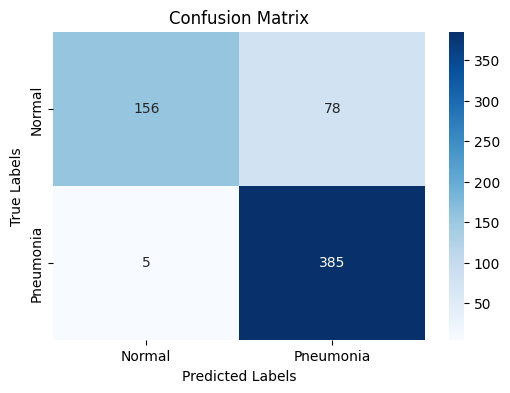

In [8]:
# Heatmap
# Display heatmap
class_labels = ['Normal', 'Pneumonia']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Function to get user input and perform diagnosis
def perform_diagnosis(model):
    while True:
        try:
            print("Enter the path to the X-ray image you want to diagnose (or 'exit' to quit):")
            user_input = input().strip()
            if user_input.lower() == 'exit':
                break
            if not os.path.isfile(user_input):
                print("Invalid path! Please enter a valid file path.")
                continue

            # Load and preprocess the user's image
            img = load_img(user_input, target_size=img_size)
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Make the diagnosis
            prediction = model.predict(img_array)
            diagnosis = "Pneumonia" if prediction[0][0] > 0.5 else "Normal"

            print(f"Diagnosis: {diagnosis}")
        except Exception as e:
            print(f"An error occurred: {e}")



In [ ]:
# Allow user to submit images for diagnosis
perform_diagnosis(model)